In [2]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess

In [3]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [4]:
names = ['agnostic3','confident2']
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'
    
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1
        
    priors[name]['net_path'] = (priors[name]['results_path'] + '/train_output/net/trained_network_round_'
                                +str(priors[name]['which_truncation'])+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')

    priors[name]['net'] = network.NetworkCorner(nbins=priors[name]['A'].nbins, marginals=priors[name]['POI_indices'], 
                                                param_names=priors[name]['A'].param_names, **hyperparams_point)

    priors[name]['net'].load_state_dict(torch.load(priors[name]['net_path']))

    with open('/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+'test3'+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)
    
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [30]:
def _get_HDI_thresholds(x, cred_level=[0.68268, 0.95450, 0.99730]):
    x = x.flatten()
    x = np.sort(x)[::-1]  # Sort backwards
    total_mass = x.sum()
    enclosed_mass = np.cumsum(x)
    idx = [np.argmax(enclosed_mass >= total_mass * f) for f in cred_level]
    levels = np.array(x[idx])
    return levels
    
def find_false_exclusions(samples,prior_samples1,
                          prior_samples2,
                          bounds,
                          contour_matrix = None,
                          predictions1 = None,
                          predictions2 = None,
                          net1 = None,
                          net2 = None,
                          trainer = None,
                          ax=None,
                          limit_credibility=0.9973,
                          levels = [0.003,0.05,0.34,0.682,0.95,0.9973,1],
                          fill=True,
                          bins=50,
                          batch_size = 1024,
                          param_names = ['m','g'],
                          colors = ['r','#FFA500','y','g','b','k'],
                          alpha = 0.5,
                          alpha_variable = False,
                         ):

    plt.figure('dummy')
    n_prior_samples = [None, None]
    prior_samples = [prior_samples1,prior_samples2]
    nets = [net1,net2]
    predictions = [predictions1, predictions2]

    if isinstance(samples,int):
        n_limits = samples
    else:
        n_limits = len(samples)

    for pi in range(2):
            
        if isinstance(prior_samples, int):
            n_prior_samples[pi] = prior_samples
        else:
            n_prior_samples[pi] = len(prior_samples)

    
        if not np.any(predictions[pi]) and not np.any(contour_matrix):
            repeat = n_prior_samples[pi] // batch_size + (n_prior_samples[pi] % batch_size > 0)
            
            predictions[pi] = trainer.infer(
                nets[pi],
                samples[pi].get_dataloader(batch_size=1,repeat=repeat),
                prior_samples[pi].get_dataloader(batch_size=batch_size)
            )
        
    if not np.any(contour_matrix):
        for i in range(n_limits):
            
            for pi in range(2):
            
                predictions_i = copy.deepcopy(predictions[pi])
        
                predictions_i[0].logratios = predictions[pi][0].logratios[i*n_prior_samples[pi]:(i+1)*n_prior_samples[pi]]
                predictions_i[0].params = predictions[pi][0].params[i*n_prior_samples[pi]:(i+1)*n_prior_samples[pi]]
                predictions_i[1].logratios = predictions[pi][1].logratios[i*n_prior_samples[pi]:(i+1)*n_prior_samples[pi]]
                predictions_i[1].params = predictions[pi][1].params[i*n_prior_samples[pi]:(i+1)*n_prior_samples[pi]]
        
                counts, _ = swyft.get_pdf(
                    predictions_i,
                    param_names,
                    bins = bins,
                )

                if i==0 and pi==0:
                    X,Y = np.meshgrid(np.linspace(0,counts.shape[0]-1,counts.shape[0]),np.linspace(0,counts.shape[1]-1,counts.shape[1]))
                    matrix_total = np.zeros(X.shape)
                    matrices = [np.ones(X.shape),np.ones(X.shape)]
                
                levels_limits=sorted(_get_HDI_thresholds(counts,cred_level=[0,limit_credibility]))
                limit_contour = plt.contourf(counts.T,levels=levels_limits)

                for collection in limit_contour.collections:
                    for path in collection.get_paths():
                        mask = path.contains_points(np.vstack((X.flatten(), Y.flatten())).T,radius=1e-9)
                        mask = mask.reshape(X.shape)
                        matrices[pi][mask] = 0
            
            matrix_total += np.logical_and(matrices[0]==1, matrices[1]==0).astype(int)
    
    else:
        matrix_total = contour_matrix

    if not ax:
        fig = plt.figure()
        fig.add_subplot(1,1,1)
        ax = fig.axes[0]
    
    for li in range(len(levels)-1):
        ax.contourf(matrix_total,
                    levels=[levels[li]*n_limits,levels[li+1]*n_limits],
                    extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]],
                    colors = colors[li],
                    alpha = (li+2)*alpha/len(levels) if alpha_variable else alpha,
                   )

    plt.close('dummy')
    
    if not ax:
        return matrix_total,fig
    else:
        return matrix_total,ax

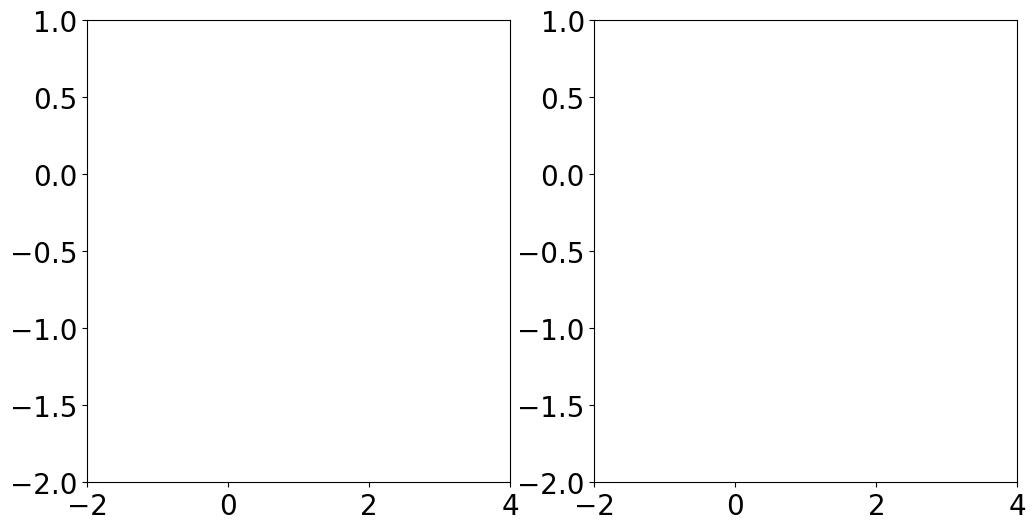

In [33]:
fig = plt.figure(figsize=(12,6))
for i in range(2):
    fig.add_subplot(1,2,i+1)
    name = names[i]
    _ = find_false_exclusions(samples = 10, 
                              
                              prior_samples1 = 10_000,
                              predictions1=priors[name]['predictions'], 
                              
                              prior_samples2 = 10_000, 
                              predictions2=priors[name]['predictions'],
                              
                              bounds = [priors[name]['bounds'][0], priors[name]['bounds'][1]],
                              ax=fig.axes[-1],
                             )
    

fig.savefig(thesis_figs+'false_exclusions.pdf')